# **Capstone Project - RSNA Pneumonia Detection Challenge**

Group 6-CV 1:

Contributor - Ashish Tiwari, Kanishk Sanger, Ninad Mahajan, Tushar Bisht, Avinash Kumra Sharma

Mentor - Mr. Rohit raj

# **Data Source: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data**

# **Import Packages**

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.2'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

cwd_old = os.getcwd()
print('\nWorking Directory: ', cwd_old)

os.chdir('/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_set')
print('Working directory has been changed')

cwd_new = os.getcwd()
print('\nCurrent Working Directory: ', cwd_new)


Working Directory:  /content
Working directory has been changed

Current Working Directory:  /content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_set


In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 2.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
import pydicom as dcm
from glob import glob
from skimage.transform import resize
from skimage import io, measure
import cv2, random
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras

In [ ]:
data_dir = os.path.join(cwd_new + 'data/')
train_images = os.path.join(data_dir + 'stage_2_train_images/')
test_images = os.path.join(data_dir + 'stage_2_test_images/')
output_dir = os.path.join(cwd_new + 'output/')
MODEL_WEIGHTS = os.path.join(cwd_new + 'model_weights/')
TRAIN_IMAGES_DIR = os.path.join(data_dir + 'stage_2_train_images_png/')

# No need to run these commands from now on as the directory has been created:

#if not os.path.exists(TRAIN_IMAGES_DIR): os.makedirs(TRAIN_IMAGES_DIR)
#if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

#if not os.path.exists(data_dir):
  #os.makedirs(data_dir)

#if not os.path.exists(train_images):
  #os.makedirs(train_images)

#if not os.path.exists(test_images):
  #os.makedirs(test_images)

#if not os.path.exists(output_dir):
  #os.makedirs(output_dir)

# USE GPU FOR MODEL TRAINING
config = tf.compat.v1.ConfigProto(log_device_placement = True, allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)
list_gpu = tf.config.experimental.list_physical_devices(device_type = 'GPU')
if len(list_gpu)==1: strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else: strategy = tf.distribute.MirroredStrategy()
print('Num GPUs Available: ', len(list_gpu))
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
print('Mixed precision enabled')


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Num GPUs Available:  1
Mixed precision enabled


In [ ]:
#Follwing series of commands related to kaggle need not to be executed as the dataset has been downloaded:
#!pip install -q kaggle

In [ ]:
#Upgrading the kaggle installation
#!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
#Choose the kaggle.json file that you downloaded
#from google.colab import files
#files.upload()

In [ ]:
#Make directory named kaggle and copy kaggle.json file there.
#!mkdir ~/.kaggle

In [ ]:
#! cp kaggle.json ~/.kaggle/

In [ ]:
#Change the permissions of the file.
#! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#To check if everything's okay or not
#!kaggle datasets list

In [ ]:
#Download the Pneumonia Detection Dataset
#!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [ ]:
 #Unzipping the dowloaded dataset

#import zipfile

#file_name = 'rsna-pneumonia-detection-challenge.zip'

#extract_file = zipfile.ZipFile(file_name, 'r')
#extract_file.extractall()

In [ ]:
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print('Current Working Directory: {}'.format(os.getcwd()))
print('Folders and Files present in the current directory: {}'.format(os.listdir()))

Current Working Directory: /content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_set
Folders and Files present in the current directory: ['kaggle.json', 'rsna-pneumonia-detection-challenge.zip', 'GCP Credits Request Link - RSNA.txt', 'stage_2_detailed_class_info.csv', 'stage_2_sample_submission.csv', 'stage_2_test_images', 'stage_2_train_images', 'stage_2_train_labels.csv']


In [ ]:
train_labels = pd.read_csv('stage_2_train_labels.csv')
print('First five rows of Training set:\n', train_labels.head())

First five rows of Training set:
                               patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


# **Exploratory Data Analysis (EDA)**

# Here as a part of EDA, we will:

1. Start with understanding of the data with a brief on train/test labels and respective class info
2. Look at the first five rows of both the csvs (train and test)
3. Identify how are classes and target distributed
4. Check the number of patients with 1, 2, ... bounding boxes
5. Read and extract metadata from dicom files
6. Perform analysis on some of the features from dicom files
7. Check some random images from the training dataset
8. Draw insights from the data at various stages of EDA





# **Reading CSVs**

**Images for the current stage in the stage_2_train_images and stage_2_test_images-**

Training data: stage_2_train_labels.csv

stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

In [ ]:
print('--'*15, 'Reading Datasets (two csv files)', '--'*15)
train_labels = pd.read_csv('/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_set/stage_2_train_labels.csv')
class_info = pd.read_csv('/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_set/stage_2_detailed_class_info.csv')

print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Number of duplicates in patientID in train labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in patientID in class info dataframe: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

------------------------------ Reading Datasets (two csv files) ------------------------------
Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns
Number of duplicates in patientID in train labels dataframe: 3543
Number of duplicates in patientID in class info dataframe: 3543


In [ ]:
print('--'*10, 'First five rows of both dataframes (train_labels, class_info)', '--'*10)
print('Train labels dataframe:\n'); display(train_labels.head())
print('\nClass info dataframe:\n'); display(class_info.head())

-------------------- First five rows of both dataframes (train_labels, class_info) --------------------
Train labels dataframe:



patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


Class info dataframe:



patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [ ]:
print('Numbers of nulls in bounding boxes columns are equal to the 0s we\'ve in Target column'); print('--'*40)
print('Checking nulls in bounding boxes columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Numbers of nulls in bounding boxes columns are equal to the 0s we've in Target column
--------------------------------------------------------------------------------
Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


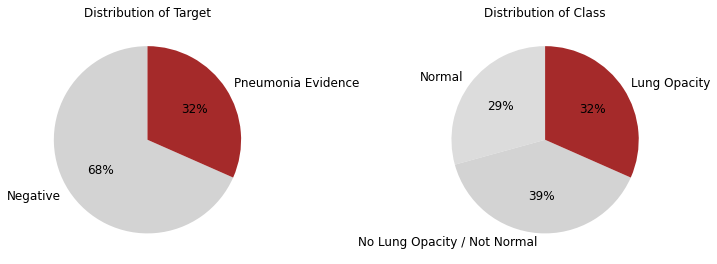

In [ ]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

In [ ]:
print('Let\'s group by patient IDs and check number of bounding boxes for each unique patient ID');print('--'*40)
bboxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bboxes, on = 'patientId', how = 'left')
print('Number of unique patient IDs in the dataset: {}'.format(len(bboxes)))
print('\nNumber of patientIDs per bboxes in the dataset')
(bboxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patientIDs_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Let's group by patient IDs and check number of bounding boxes for each unique patient ID
--------------------------------------------------------------------------------
Number of unique patient IDs in the dataset: 26684

Number of patientIDs per bboxes in the dataset


number_of_patientIDs_per_boxes
number_of_boxes                                
1                                         23286
2                                          3266
3                                           119
4                                            13

In [ ]:
print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class = pd.concat([train_labels, class_info['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 8)


In [ ]:
train_class.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  
0                1  No Lung Opacity / Not Normal  
1                1  No Lung Opacity / Not Normal  
2                1  No Lung Opacity / Not Normal  
3                1                        Normal  
4                2                  Lung Opacity

### **Observations from the CSVs**
# **Based on analysis above, some of the observations:**

1. Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height.
2. There are multiple records for patients. Number of duplicates in patientID = 3,543.
3. There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia.
4. Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity.
Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class.
5. Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class.
6. About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes!!!!

# **Reading Images**
Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

Reference= https://pydicom.github.io/pydicom/stable/old/ref_guide.html 

In [ ]:
sample_patient_id = train_labels['patientId'][0]
dcm_file = '/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_setdata/stage_2_train_images/' + '{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
print('Read the training images file names and path'); print('--'*40)
images = pd.DataFrame({'path': glob(os.path.join(train_images, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Read the training images file names and path
--------------------------------------------------------------------------------
Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [ ]:
print('Merge path from the `images` dataframe with `train_class` dataframe'); print('--'*40)
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class.shape))
del images

Merge path from the `images` dataframe with `train_class` dataframe
--------------------------------------------------------------------------------
Shape of the `train_class` dataframe after merge: (30227, 9)


In [ ]:
print('The training_data dataframe as of now stands like\n')
train_class.head()

The training_data dataframe as of now stands like



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path  
0  /content/gdrive/MyDrive/AIML Program/CV_Capsto...  
1  /content/gdrive/MyDrive/AIML Program/CV_Capsto...  
2  /content/gdrive/MyDrive/AIML Program/CV_Capsto...  
3  /content/gdrive/MyDrive/AIML Program/CV_Capsto...  
4  /content/gdrive/MyDrive/AIML Program/CV_Capsto...

In [ ]:
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition']

def parse_dicom_data(data_df, data_path):
  for col in columns_to_add:
    data_df[col] = None
  image_names = os.listdir('/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_setdata/stage_2_train_images/')
  
  for i, img_name in tqdm_notebook(enumerate(image_names)):
    imagepath = os.path.join('/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_setdata/stage_2_train_images/', img_name)
    data_img = dcm.read_file(imagepath)
    idx = (data_df['patientId'] == data_img.PatientID)
    data_df.loc[idx, 'Modality'] = data_img.Modality
    data_df.loc[idx, 'PatientAge'] = pd.to_numeric(data_img.PatientAge)
    data_df.loc[idx, 'PatientSex'] = data_img.PatientSex
    data_df.loc[idx, 'BodyPartExamined'] = data_img.BodyPartExamined
    data_df.loc[idx, 'ViewPosition'] = data_img.ViewPosition   

In [ ]:
#parse_dicom_data(train_class, '/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_setdata/stage_2_train_images/')

0it [00:00, ?it/s]

In [ ]:
print('Saving the feature engineered dataframe for future use'); print('--'*40)
train_class.to_pickle('train_feature_engineered.pkl')

Saving the feature engineered dataframe for future use
--------------------------------------------------------------------------------


In [ ]:
train_class = pd.read_pickle('train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [ ]:
train_class.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/gdrive/MyDrive/AIML Program/CV_Capsto...       CR         51   
1  /content/gdrive/MyDrive/AIML Program/CV_Capsto...       CR         48   
2  /content/gdrive/MyDrive/AIML Program/CV_Capsto...       CR         19   
3  /content/gdrive/MyDrive/AIML Program/CV_Capsto...       CR         28   
4  /content/gdrive/MyDrive/AIML Program/CV_Capsto...       CR         32   

  PatientSex BodyPartExamined ViewPosition  
0          F            CHEST           PA  
1          F            CHEST           PA  
2          M            CHEST           AP  
3          M            CHEST           PA  
4          F            CHEST           AP

In [ ]:
print('As expected unique in `BodyPartExamined` is: {}'.format(train_class['BodyPartExamined'].unique()[0]))
print('Unique in `Modality` is: {}'.format(train_class['Modality'].unique()[0])); print('--'*40)

As expected unique in `BodyPartExamined` is: CHEST
Unique in `Modality` is: CR
--------------------------------------------------------------------------------


# **Understanding different View Positions**
As seen below, two View Positions that are in the training dataset are AP (Anterior/Posterior) and PA (Posterior/Anterior). These type of X-rays are mostly used to obtain the front-view. Apart from front-view, a lateral image is usually taken to complement the front-view.
## **1. Posterior/Anterior (PA):** In PA, X-Ray beam hits the posterior (back) part of the chest before the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film.

## **2.Anterior/Posterior (AP):** Attimes it's not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. AP projection images are of lower quality than PA images. Heart size is exaggerated (cardiothoracic ratio approximately 50%)

# **Reference=** https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection#top_1st_img 

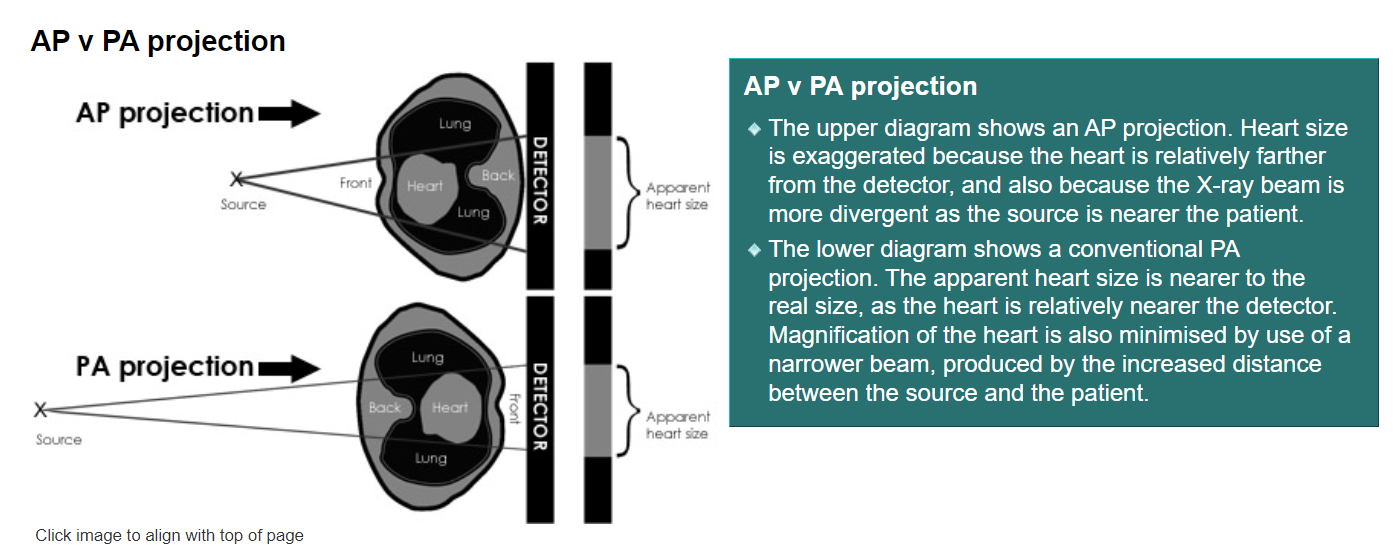

# Computed radiography (CR) : 
It is the digital replacement of conventional X-ray film radiography and offers enormous advantages for inspection tasks – the use of consumables is virtually eliminated and the time to produce an image is drastically shortened.

Get the distribution of `ViewPosition` overall and where Target = 1
Overall the distribution is almost equal for `ViewPosition` but where there's a Pneumonia Evidence, `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior
--------------------------------------------------------------------------------


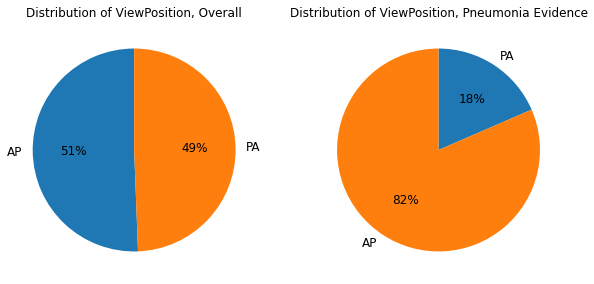

In [ ]:
print('Get the distribution of `ViewPosition` overall and where Target = 1')
print('Overall the distribution is almost equal for `ViewPosition` but where there\'s a Pneumonia Evidence, `ViewPosition` is `AP`')
print('AP: Anterior/Posterior, PA: Posterior/Anterior'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'Distribution of ViewPosition, Overall', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'Distribution of ViewPosition, Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

# Exploring the bounding boxes for both view positions :

1. Centers of the rectangle would be x+width/2 and y+height/2 
2. We will make use of (bboxes_scatter) function in the (eda). 

Plot x and y centers of bounding boxes
--------------------------------------------------------------------------------


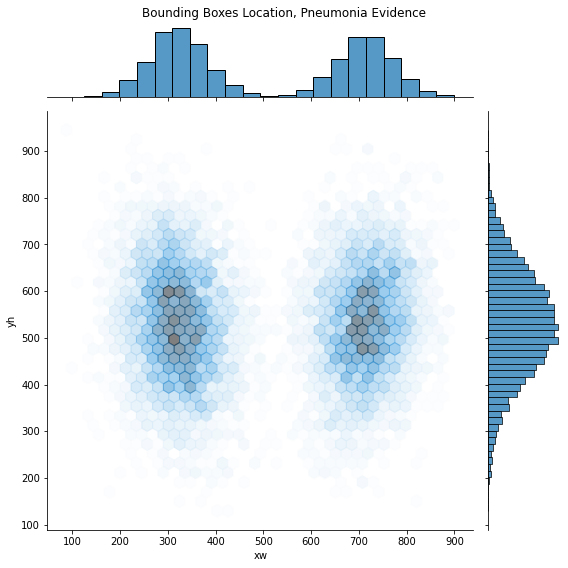

In [ ]:
print('Plot x and y centers of bounding boxes'); print('--'*40)
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes, 
                  kind = 'hex', alpha = 0.5, size = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

Reference for this function & plots: https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda

In [ ]:
def bboxes_scatter(data, color_point, color_window, text):
  fig, ax = plt.subplots(1, 1, figsize = (7, 7))
  plt.title('Plotting centers of Lung Opacity\n{}'.format(text))
  data.plot.scatter(x = 'xw', y = 'yh', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = ".", color = color_point)
  for i, crt_sample in data.iterrows():
         ax.add_patch(Rectangle(xy = (crt_sample['x'], crt_sample['y']), width = crt_sample['width'], height = crt_sample['height'], alpha = 3.5e-3, color = color_window))

**Exploring the bounding boxes centers for `ViewPositions` for random sample 1000**

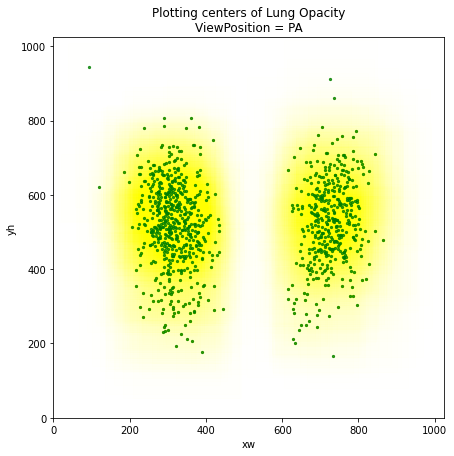

In [ ]:
data_PA = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
data_AP = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)

bboxes_scatter(data_PA, 'green', 'yellow', 'ViewPosition = PA')

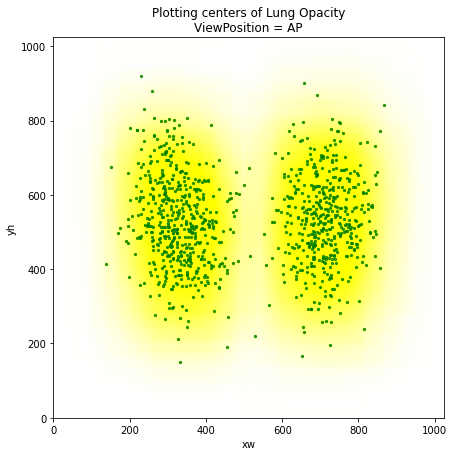

In [ ]:
bboxes_scatter(data_AP, 'green', 'yellow', 'ViewPosition = AP')

# **Observations: BodyPartExamined & ViewPosition**
**Above we saw,**

1. BodyPartExamined is unique for all cases and is CHEST in the training dataset and that was also expected.
2. Unique in Modality is CR i.e. Computer Radiography
3. Overall ViewPosition is almost equally distributed in the training dataset but for cases where Target=1, most of the view position are AP.

Checking outliers in `PatientAge
--------------------------------------------------------------------------------
Minimum `PatientAge` in the training dataset: 1
Maximum `PatientAge` in the training dataset: 155
75th Percentile of `PatientAge` in the training dataset: 59.0
`PatientAge` in upper whisker for box plot: 84.0



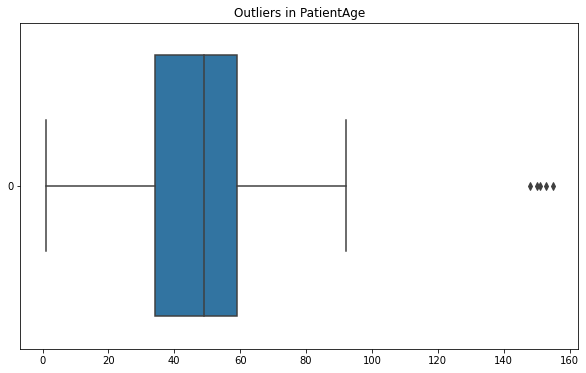

In [ ]:
print('Checking outliers in `PatientAge'); print('--'*40)
print('Minimum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].min()))
print('Maximum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].max()))
print('75th Percentile of `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].quantile(0.75)))
print('`PatientAge` in upper whisker for box plot: {}'.format(train_class['PatientAge'].quantile(0.75) + (train_class['PatientAge'].quantile(0.75) - train_class['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

We can make use of pd.clip() to trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [ ]:
print('Using pd.clip to set upper threshold of 100 for age and remove outliers'); print('--'*40)
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

Using pd.clip to set upper threshold of 100 for age and remove outliers
--------------------------------------------------------------------------------


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int64

Get the distribution of `PatientAge` overall and where Target = 1
--------------------------------------------------------------------------------


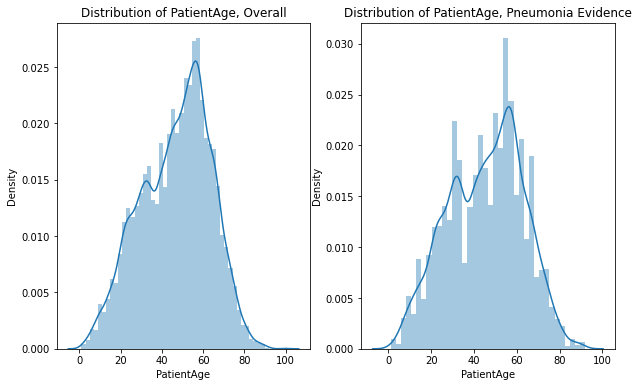

In [ ]:
print('Get the distribution of `PatientAge` overall and where Target = 1'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Distribution of PatientAge, Overall'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge, Pneumonia Evidence'))

# **Using Binning Method for PatientAge feature**

We'll make use of a pd.cut which is 'Bin values into discrete intervals'. Use of this method is recommended when need is to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. Supports binning into an equal number of bins, or a pre-specified array of bins.

Reference = https://pandas.pydata.org/docs/reference/api/pandas.cut.html 

In [ ]:
print('The minimum and maximum recorded age of the patients are {} and {} respectively.'.format(train_class['PatientAge'].min(), train_class['PatientAge'].max()))


The minimum and maximum recorded age of the patients are 1 and 100 respectively.


In [ ]:
print('Creating Age Binning field', '--'*40)
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class['AgeBins'].value_counts()

Creating Age Binning field --------------------------------------------------------------------------------


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Value counts of the age bin field created
--------------------------------------------------------------------------------


Counts of Age Bins, Overall  Counts of Age Bins, Target=1
<=26                          3972                          1478
<=50                         12157                          3917
<=75                         13318                          3895
<=100                          780                           265

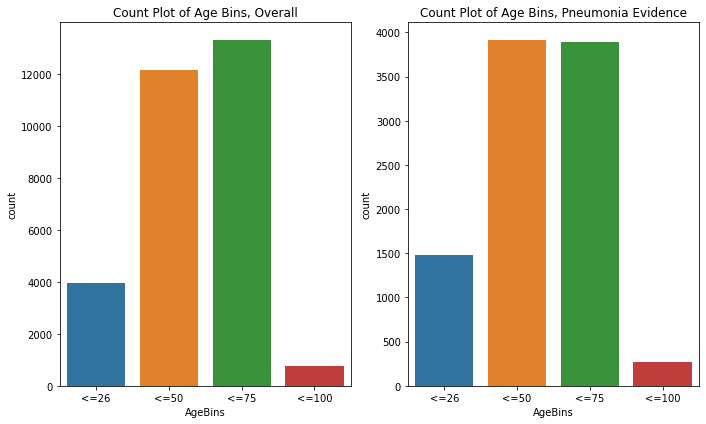

In [ ]:
print('Value counts of the age bin field created'); print('--'*40)
display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `AgeBins` for random sample = 200


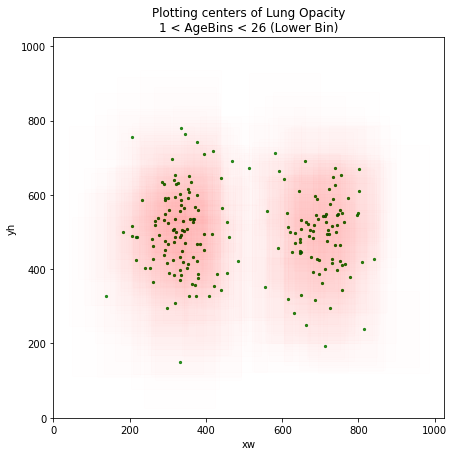

In [ ]:
print('Exploring the bounding boxes centers for `AgeBins` for random sample = 200')
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '<=26'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1,'green','red','1 < AgeBins < 26 (Lower Bin)')

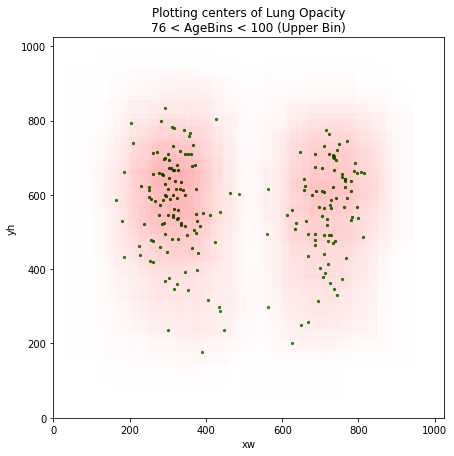

In [ ]:
bboxes_scatter( df2, 'green','red', '76 < AgeBins < 100 (Upper Bin)')

Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender
--------------------------------------------------------------------------------


% Gender, Overall  % Gender, Target=1
F               0.43                0.42
M               0.57                0.58

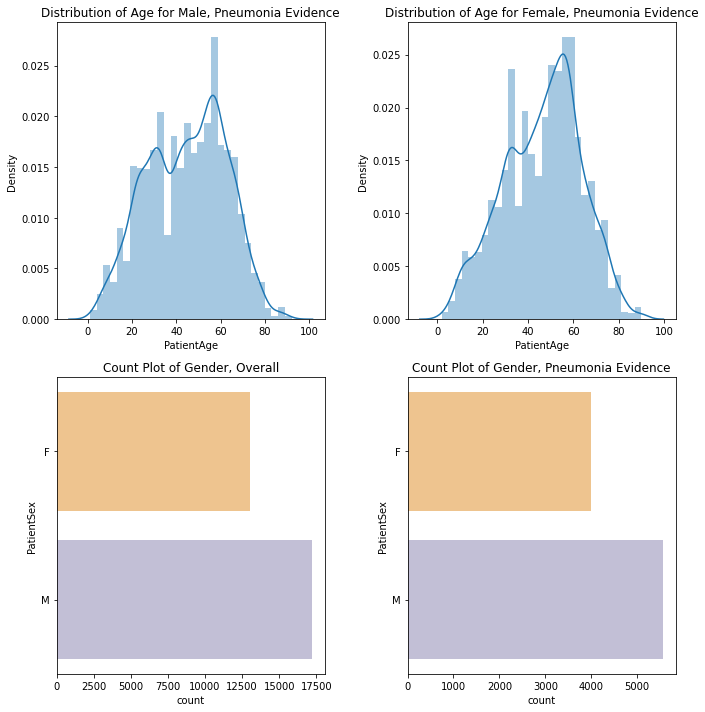

In [ ]:
print('Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender'); print('--'*40)
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class.loc[(train_class['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `PatientSex` for random sample = 1000


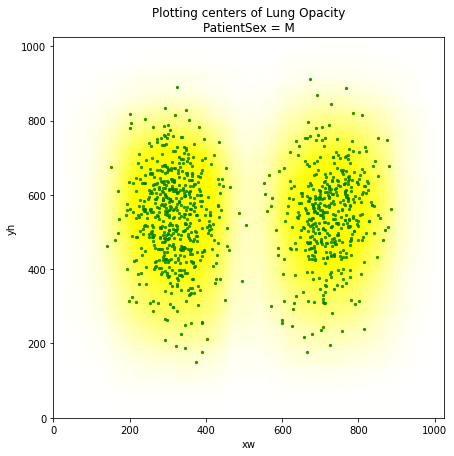

In [ ]:
print('Exploring the bounding boxes centers for `PatientSex` for random sample = 1000')
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, 'green', 'yellow', 'PatientSex = M')

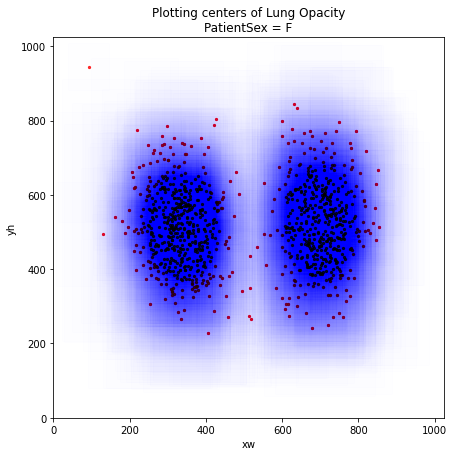

In [ ]:
bboxes_scatter(df2, 'red', 'blue', 'PatientSex = F')

# **Observations: PatientAge & PatientSex**

**Above we saw,**

1. For PatientAge we saw the distribution for both overall and where there were evidence of Pneumonia. Used binning to check the count of age bins. Count was highest for age group 40-78 both overall and with Pneumonia Evidence.
2. Saw distribution of age for Male and Female with Pneumonia Evidence.
3. Dataset had more Males (57%-58%) than Females (42%-43%).

# **Only PatientAge, PatientSex and ViewPosition are useful features from metadata.**

# Dropping the other features from train_class dataframe and save that as a pickle file

In [ ]:
train_class.drop(['BodyPartExamined', 'Modality', 'AgeBins'], inplace = True, axis = 1)
train_class.to_pickle('train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path PatientAge PatientSex  \
0  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         51          F   
1  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         48          F   
2  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         19          M   
3  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         28          M   
4  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         32          F   

  ViewPosition  
0           PA  
1           PA  
2           AP  
3           PA  
4           AP

# **Check some random samples from training data**
**Checking some random samples as below:**

1. Different classes i.e. Normal, No Lung Opacity / Not Normal and Lung Opacity
2. Two view positions that we have in the dataset
3. For the one with Pneumonia Evidence and age = 92

Now, we will make use of custom module (eda) and function (plot_dicom_images) already imported earlier to visualize the images.

# **Plotting DICOM Images**

In [ ]:
def show_dicom_images(data, df, img_path):
  img_data = list(data.T.to_dict().values())
  f, ax = plt.subplots(3, 3, figsize = (16, 18))
  
  for i, row in enumerate(img_data):
    image = row['patientId'] + '.dcm'
    path = os.path.join(img_path, image)
    data = dcm.read_file(path)
    rows = df[df['patientId'] == row['patientId']]
    age = rows.PatientAge.unique().tolist()[0]
    sex = data.PatientSex
    part = data.BodyPartExamined
    vp = data.ViewPosition
    modality = data.Modality
    data_img = dcm.dcmread(path)
    ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                            .format(row['patientId'], age, sex, part,
                                    vp, modality, row['Target'],
                                    row['class'], row['x'],
                                    row['y'], row['width'],
                                    row['height']))
    box_data = list(rows.T.to_dict().values())
    
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                                        width = row['width'], height = row['height'],
                                        color = 'blue', alpha = 0.15))
  plt.show()

Checking sample for different classes


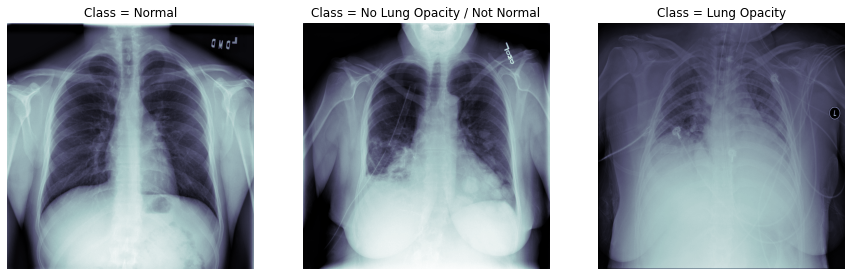

In [ ]:
print('Checking sample for different classes')
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[1]
ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()

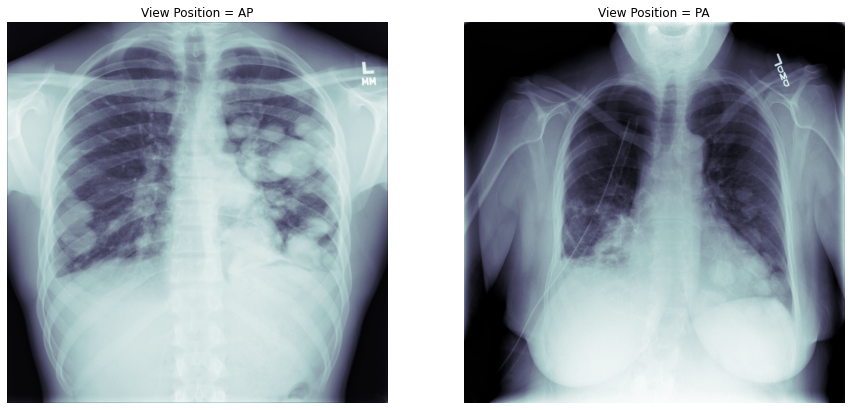

In [ ]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]
ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

# **Target = 0**

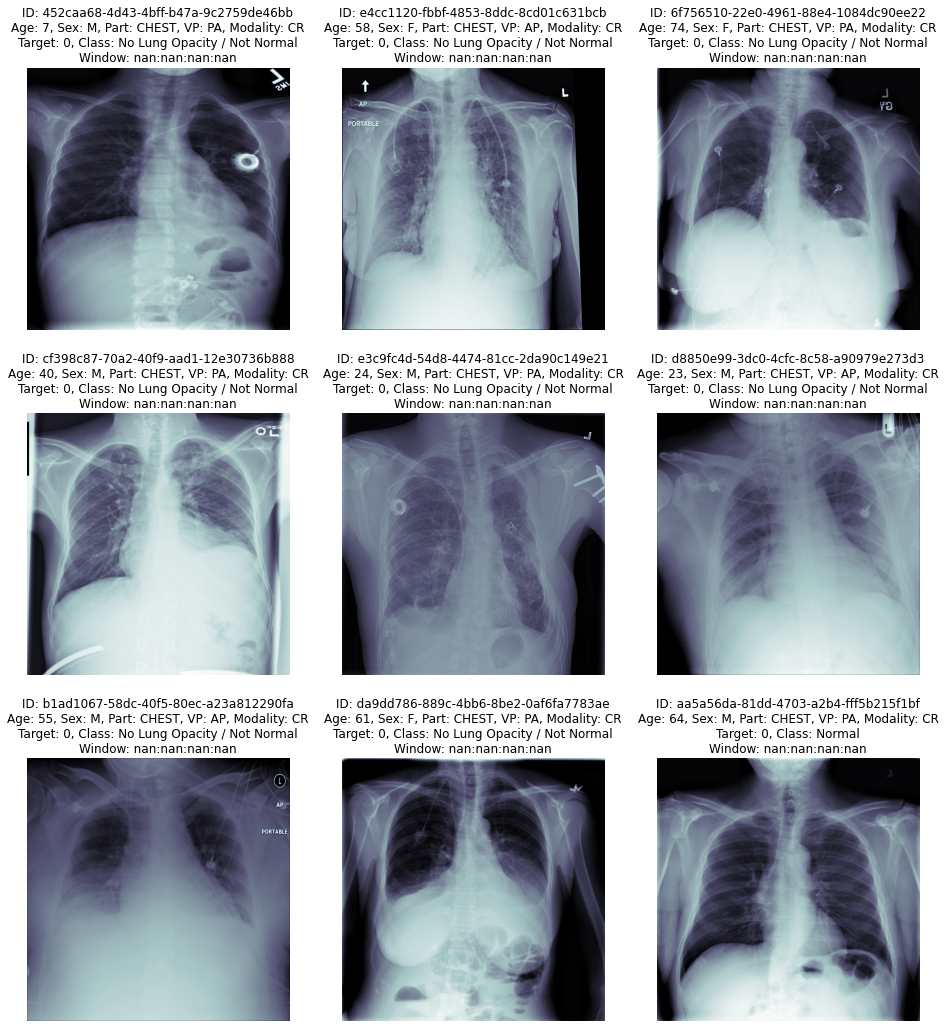

In [ ]:
# this function is a part of custom module imported earlier (`eda`)
show_dicom_images(data = train_class.loc[(train_class['Target'] == 0)].sample(9), 
                  df = train_class, img_path = '/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_setdata/stage_2_train_images')

# As the above subplots are of the images which belong to either "Normal" or "No Lung Opacity / Not Normal", hence no bounding box is observed.

# **Target = 1**

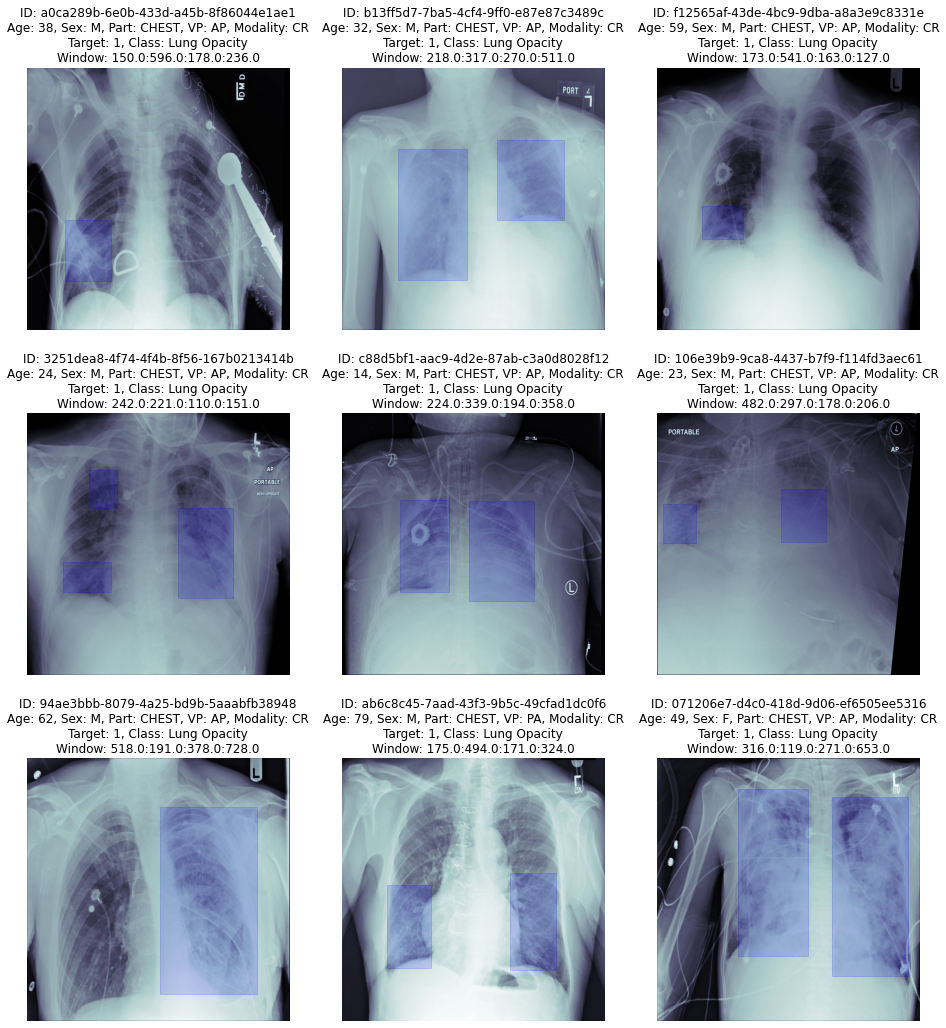

In [ ]:
# this function is a part of custom module imported earlier (`eda`)
show_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9), 
                  df = train_class, img_path = '/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_setdata/stage_2_train_images')

# In the above subplots, we can see that the area covered by the box (in blue colour) depicts the area of interest i.e., the area in which the opacity is observed in the Lungs.

# CNN Segmentation

**Split into Train & Valid**

Splitting the list of training images in train and valid images

Random shuffle the list of training images

In [ ]:
print('Create training and valid sets. Contains list of filenames'); print('--'*40)
image_fns = os.listdir(train_images)
random.shuffle(image_fns)
val_size = round(len(image_fns)/10)
train_size = len(image_fns) - val_size

image_fns_train = image_fns[:train_size]
image_fns_val = image_fns[train_size: (train_size + val_size)]

print('Number of training samples: {}'.format(train_size))
print('Number of valid samples: {}'.format(val_size))

Create training and valid sets. Contains list of filenames
--------------------------------------------------------------------------------
Number of training samples: 24016
Number of valid samples: 2668


# **Load Pneumonia Evidence**


1. **Dictionary contains pairs per row.**

2. **If there are multiple pneumonia evidence for a patient then the dictionary would contain multiple list tagged to a patient id key. If there's no pneumonia evidence it will have an empty list.**

 Reference: https://www.kaggle.com/jonnedtc/cnn-segmentation-connected-components

In [ ]:
import numpy as np, pandas as pd
import os, random, pydicom, keras
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import cv2

from skimage import io, measure
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as patches

PATH = '/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/'
DATA_DIR = os.path.join(PATH + 'Data_set/')
#if not os.path.exists(DATA_DIR): os.makedirs(DATA_DIR)



def get_pneumonia_evidence(filename):
    pneumonia_evidence = {}
    df = pd.read_csv(DATA_DIR + filename)

    for _, row in df.iterrows():
        fn = row[0]
        loc = row[1:5]
        pneumonia = row[5]
        if pneumonia == 1:
            loc = [int(float(i)) for i in loc]
            if fn in pneumonia_evidence:
                pneumonia_evidence[fn].append(loc)
            else:
                pneumonia_evidence[fn] = [loc]
    return pneumonia_evidence

class visualize(keras.utils.Sequence):

    def __init__(self, folder, fns, pneumonia_evidence = None, 
                 batch_size = 32, image_size = 256, 
                 shuffle = True, augment = False, predict = False):
        self.folder = folder
        self.fns = fns
        self.pneumonia_evidence = pneumonia_evidence
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()

    def __load__(self, fn):
        img = pydicom.dcmread(os.path.join(self.folder, fn)).pixel_array
        msk = np.zeros(img.shape)
        fn = fn.split('.')[0]
        if fn in self.pneumonia_evidence:
            for loc in self.pneumonia_evidence[fn]:
                x, y, w, h = loc
                msk[y:y+h, x:x+w] = 1
        img = resize(img, (self.image_size, self.image_size), mode = 'reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode = 'reflect') > 0.5
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk

# Function to plot masks that are generated using `generator` function above
def plot_masks(df, path, image_fns, pneumonia_evidence):
    sample_patient_id = random.choice(list(df.loc[(df['Target'] == 1), 'patientId']))
    sample_fn = sample_patient_id + '.dcm'
    sample_details = df.loc[df['patientId'] == sample_patient_id]
    
    g = visualize(path, image_fns, pneumonia_evidence)
    img, msk = g.__load__(sample_fn)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 6))
    
    _ = ax1.imshow(img[:,:,0], cmap = plt.cm.bone); _ = ax1.axis('off')
    _ = ax2.imshow(msk[:,:,0]); _ = ax2.axis('off')
    _ = ax3.imshow(cv2.bitwise_and(img, img, mask = msk.astype(np.uint8)), 
                cmap = plt.cm.bone); _ = ax3.axis('off')
    _ = ax1.set_title('{}\nAge: {}, Gender: {}, VP: {}\nSample Image'.format(sample_patient_id,
                list(sample_details['PatientAge'].unique())[0], 
                list(sample_details['PatientSex'].unique())[0],
                list(sample_details['ViewPosition'].unique())[0]))
    _ = ax2.set_title('{}\nAge: {}, Gender: {}, VP: {}\nMask for Sample Image'.format(sample_patient_id,
                list(sample_details['PatientAge'].unique())[0], 
                list(sample_details['PatientSex'].unique())[0],
                list(sample_details['ViewPosition'].unique())[0]))
    _ = ax3.set_title('{}\nAge: {}, Gender: {}, VP: {}\nMask overlay over Image'.format(sample_patient_id,
                list(sample_details['PatientAge'].unique())[0], 
                list(sample_details['PatientSex'].unique())[0],
                list(sample_details['ViewPosition'].unique())[0]))
    plt.subplots_adjust(top = 0.4)
    plt.tight_layout()

In [ ]:
print('Load pneumonia evidence dictionary from `stage_2_train_labels.csv`'); print('--'*40)
pneumonia_evidence = get_pneumonia_evidence(filename = 'stage_2_train_labels.csv')

Load pneumonia evidence dictionary from `stage_2_train_labels.csv`
--------------------------------------------------------------------------------


In [ ]:
list(pneumonia_evidence.keys())[0], list(pneumonia_evidence.values())[0]

('00436515-870c-4b36-a041-de91049b9ab4',
 [[264, 152, 213, 379], [562, 152, 256, 453]])

**Plot Masks generated using `generator` function,randomly**

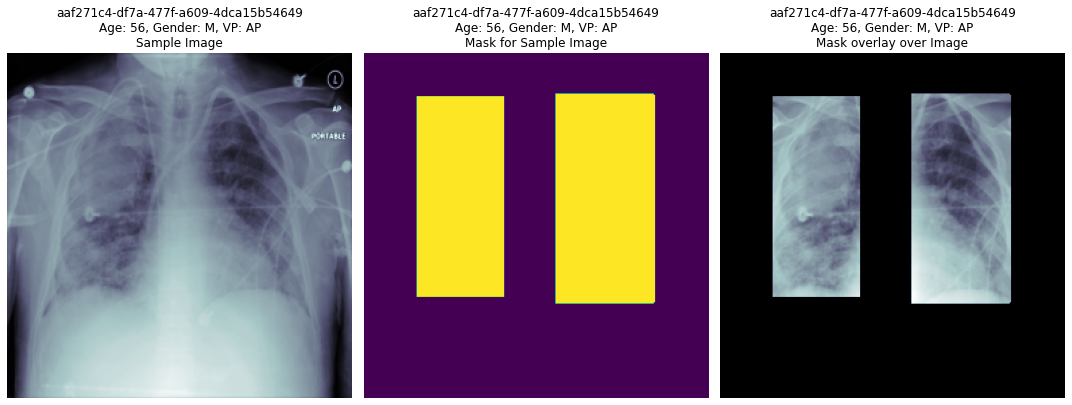

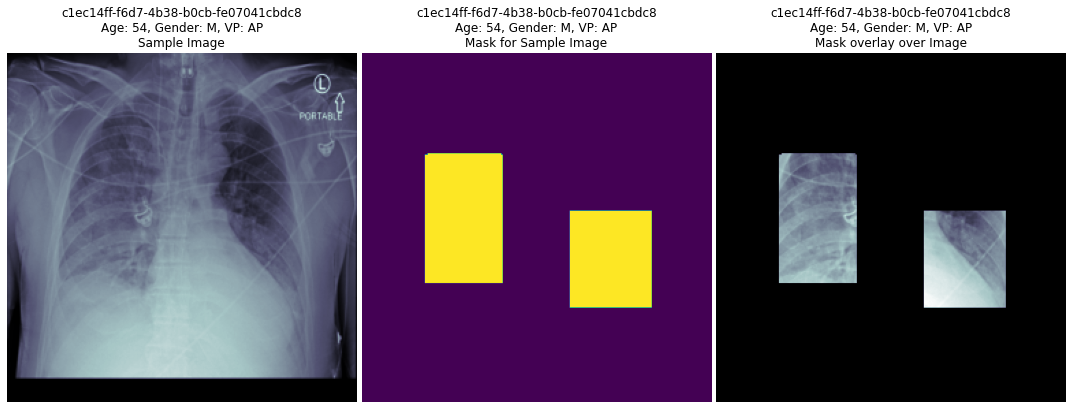

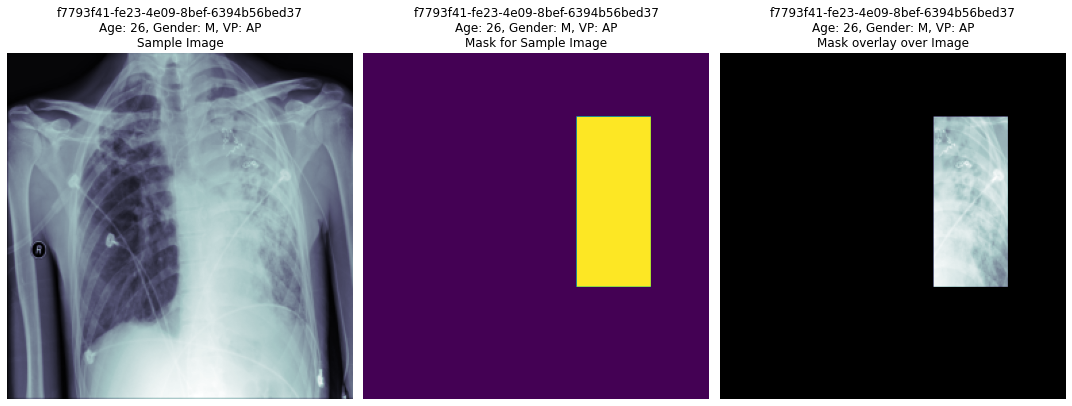

In [ ]:
plot_masks(train_class, train_images, image_fns, pneumonia_evidence)
plot_masks(train_class, train_images, image_fns, pneumonia_evidence)
plot_masks(train_class, train_images, image_fns, pneumonia_evidence)

# **Pneumonia_Classification_Model**

In [ ]:
# Read `train_class_features.pkl` file, saved as EDA & Data Prep Module
train_class = pd.read_pickle('/content/gdrive/MyDrive/AIML Program/CV_Capstone_project/Data_set/train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path PatientAge PatientSex  \
0  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         51          F   
1  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         48          F   
2  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         19          M   
3  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         28          M   
4  /content/gdrive/MyDrive/AIML Program/CV_Capsto...         32          F   

  ViewPosition  
0           PA  
1           PA  
2           AP  
3           PA  
4           AP

In [ ]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))
path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 4)

patientId    26684
path         26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

# **Now, Lets Convert dicom to png images**

In [ ]:
#image_lists = [f for f in os.listdir(train_images)]
#for f in tqdm_notebook(image_lists): 
     #ds = dcm.read_file(train_images + f)
     #img = ds.pixel_array
     #cv2.imwrite(TRAIN_IMAGES_DIR + f.replace('.dcm','.png'), img)

Lets Split the data in train, valid and test sets

In [ ]:
image_list = list(path_class_target['path'])
random.shuffle(image_list)
val_size = round(len(image_list)/10)
test_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

In [ ]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(21348, 3)
VALID:(2668, 3)
TEST:(2668, 3)


In [ ]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(df_train['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.77
1    0.23
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.78
1    0.22
Name: Target, dtype: float64

In [ ]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle('train_data.pkl')
df_valid.to_pickle('valid_data.pkl')
df_test.to_pickle('test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


# **Model - DenseNet121**

Reference: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

Lets plot accuracy, average precision and f1_score with the help of this refrence

In [ ]:
import tensorflow as tf
assert tf.__version__ >= '2.0'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize

import pydicom as dcm, cv2
from PIL import Image
import pandas as pd
import numpy as np
import keras
import math
random_state = 2020

# ROC AUC as a Metric
# Reference: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def roc_auc(y_true, y_pred):
    return tf.compat.v1.py_function(roc_auc_score, (y_true, y_pred), tf.double)

# Average Precision as a Metric
import tensorflow.keras.backend as K
def average_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1 score as a Metric
# Reference: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Data generator
class DataGenerators:
    def __init__(self, df_train, df_valid, df_test, batch_size, path,
                 img_size = (224, 224), class_mode = 'binary',
                 random_state = 2020):
        self.df_train = df_train
        self.df_valid = df_valid
        self.df_test = df_test
        self.batch_size = batch_size
        self.img_size = img_size
        self.path = path
        self.class_mode = class_mode
        
        train_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rotation_range = 20, width_shift_range = 0.2,
            height_shift_range = 0.2, zoom_range = 0.2,
            horizontal_flip = True, rescale = 1/255.
            )
        
        valid_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input, 
            rescale = 1/255.
            )
        
        test_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rescale = 1/255.
            )
        
        print('Train Generator Created', '--'*20)
        self.train_generator = train_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_train,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = True
            )
        print('Validation Generator Created', '--'*20)
        self.valid_generator = valid_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_valid,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        print('Test Generator Created', '--'*20)
        self.test_generator = test_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_test,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        
        self.step_size_train = math.ceil(
            self.train_generator.n//self.train_generator.batch_size + 1
            )
        self.step_size_valid = math.ceil(
            self.valid_generator.n//self.valid_generator.batch_size + 1
            )
        self.step_size_test = math.ceil(
            self.test_generator.n//self.test_generator.batch_size + 1
            )

In [ ]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 5
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_densenet.h5'
FINAL_MODEL = 'best_densenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

In [ ]:
df_train['Target'] = df_train['Target'].astype(str); 
df_valid['Target'] = df_valid['Target'].astype(str); 
df_test['Target'] = df_test['Target'].astype(str)

In [ ]:
print('Create generators for training, validation and test dataframes'); print('--'*40)
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = BATCH_SIZE, 
                            path = TRAIN_IMAGES_DIR, 
                            img_size = (IMAGE_SIZE, IMAGE_SIZE), 
                            class_mode = 'binary',
                            random_state = random_state)

Create generators for training, validation and test dataframes
--------------------------------------------------------------------------------
Train Generator Created ----------------------------------------
Found 21348 validated image filenames belonging to 2 classes.
Validation Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.
Test Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.


In [ ]:
def build_model():
    print('Create a `DenseNet121` model'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'DenseNet121')
    
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    
    callbacks = [cp, csv_logger, lrscheduler]
    return callbacks

In [ ]:
print('Lets fit the model.....')
K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks = callbacks()
    train_generator = generators.train_generator
    validation_generator = generators.valid_generator
    test_generator = generators.test_generator    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = generators.step_size_train,
                                  epochs = 5, verbose = VERBOSE, 
                                  callbacks = callbacks,
                                  validation_data = validation_generator, 
                                  validation_steps = generators.step_size_valid)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `DenseNet121` model
--------------------------------------------------------------------------------
29097984/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseNet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
No

In [ ]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [ ]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy = model.evaluate_generator(generator = validation_generator, 
                                          steps = generators.step_size_valid)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.356, Accuracy: 0.841


In [ ]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         steps = generators.step_size_valid,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
84/84 [==============================] - 38s 425ms/step


In [ ]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                                        steps = generators.step_size_test,
                                        verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

Predict on the test data
--------------------------------------------------------------------------------
84/84 [==============================] - 473s 6s/step


In [ ]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2041
1     627
dtype: int64

0    2092
1     576
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.882


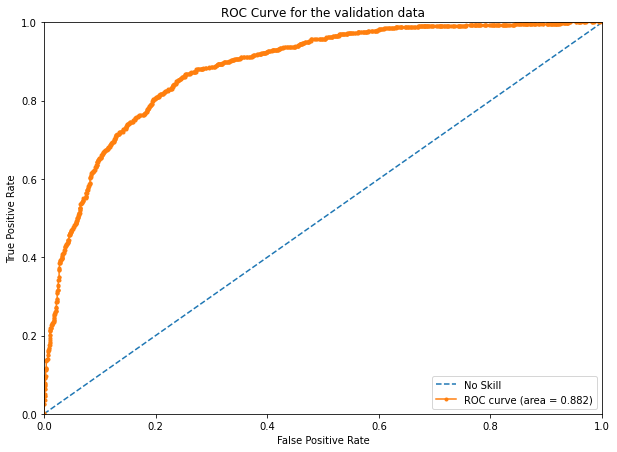

In [ ]:
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.886


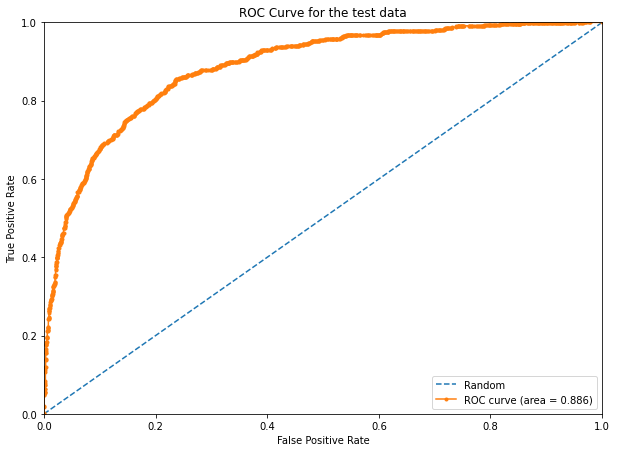

In [ ]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


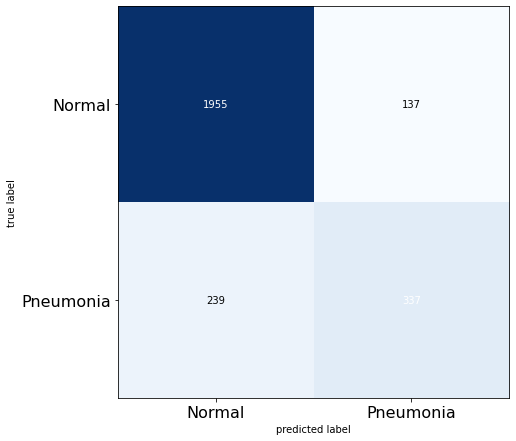

In [ ]:
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [ ]:
print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.89      0.93      0.91      2092
   Pneumonia       0.71      0.59      0.64       576

    accuracy                           0.86      2668
   macro avg       0.80      0.76      0.78      2668
weighted avg       0.85      0.86      0.85      2668

